# Deep Learning for Side-Channel Analysis

_Adrien Chuttarsing & Luca Veyrin-Forrer & Malik Kazi Aoual & Martin Bauw & Nouredine Nour_

> ## 1. Challenge introduction

> ## 2. Business case

>> ### 2.1  Embedded encryption, data and IoT
>> ### 2.2 Challenge metric and Key Performance Indicator

> ## 3. Exploratory data analysis

> ## 4. Baseline solution

> ## 5. Making a RAMP submission

# 1. Challenge introduction

This challenge is about revealing the relevance of deep learning in the field of a certain type of cyber attack: the Side-Channel Attack (SCA). SCA harvests Side-Channel Analysis information in order to breach a protected system. This information consists in physical measurements associated with the hardware on which the cryptographic algorithms are implemented. Here, we consider the use of electromagnetic measurements of a smart card as a side-channel to attack an AES encryption implementation. The project was inspired by the work of an ANSSI and CEA team https://github.com/ANSSI-FR/ASCAD formalized in a research article https://eprint.iacr.org/2018/053.pdf 

The overall advent of AI doesn't go without impacting cybersecurity, a growing and essential field for any economy in our digitalized world. Ernst and Young reports an expected global cost of US $ 6 trillions for cybersecurity breaches across all sectors by 2021.

# 2. Business case

## 2.1  Embedded encryption, data and IoT

This challenge focuses on the ability of deep learning to help in the cracking of encryption in small hardware that would typically be embedded in IoT devices. IoT devices are central among the cybersecurity concerns, since the upcoming IoT revolution translates into a massive introduction of connected devices among networks, which is directly associated with a wealth of personal and sensitive data. 

![Connected devices growth curve](images/connecteddevices.png)
**Image credit:** The Economist

Connected devices have a history of being targeted by cyber attacks since many of them aren't well protected when one consider the interest of the data if gives access to. According to the EU 2017 cybersecurity facts sheet, there will be tens of billions of connected digital devices in the EU alone by 2020.

![Estimated cost per stolen data record, per industry](images/costperrecord.png)
**Image credit:** IBM Security

Furthermore, working on AES (Advanced Encryption Standard) gives substantial legitimacy to machine learning as a prominent player in cybersecurity, since it is a US federal government standard. AES is a symmetric key algorithm, a unique key is shared by both encryption and decryption processes. Depending on key length, AES is even said to be used to secure US classified information (192 or 256 bits keys). Here, the AES implementation being attacked relies on 16-byte/128 bits keys.

## 2.2 Challenge metric and Key Performance Indicator

Area under rank curve: how much did we spend
KPI: correlated to anything protected by AES code

# <center><span style="color:blue">3. Exploratory data analysis</span></center>
## Description of the data
### Requirements


In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

### Data loading

In [2]:
in_file = h5py.File('data/ASCAD.h5','r')
# Load profiling traces
X_train = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
# Load profiling labels
y_train = np.array(in_file['Profiling_traces/labels'])
# Load attacking traces
X_test = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
# Load attacking labels
y_test = np.array(in_file['Attack_traces/labels'])

df_train = pd.DataFrame(X_train)
df_test  = pd.DataFrame(y_train)

### A first glympse

In [3]:
df_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,19.988140,19.215220,14.979940,8.371440,0.590740,-7.690040,-16.481780,-25.824800,-35.337040,-43.645820,...,-50.366580,-45.824400,-41.853060,-37.731280,-31.992800,-23.645800,-13.219660,-2.214860,7.235560,13.70676
std,2.756678,2.856043,3.127589,3.253264,3.150778,3.083873,3.083877,3.130045,2.970593,2.475944,...,1.688128,1.560966,1.428786,1.641634,2.285531,3.008622,3.475504,3.363897,2.729106,1.87719
min,10.000000,9.000000,3.000000,-3.000000,-10.000000,-17.000000,-26.000000,-35.000000,-44.000000,-52.000000,...,-56.000000,-51.000000,-47.000000,-43.000000,-38.000000,-32.000000,-22.000000,-13.000000,-1.000000,7.00000
25%,18.000000,17.000000,13.000000,6.000000,-2.000000,-10.000000,-19.000000,-28.000000,-38.000000,-46.000000,...,-52.000000,-47.000000,-43.000000,-39.000000,-34.000000,-26.000000,-16.000000,-5.000000,5.000000,12.00000
50%,20.000000,19.000000,15.000000,8.000000,0.000000,-8.000000,-16.000000,-26.000000,-35.000000,-44.000000,...,-50.000000,-46.000000,-42.000000,-38.000000,-32.000000,-24.000000,-13.000000,-2.000000,7.000000,14.00000
75%,22.000000,21.000000,17.000000,11.000000,3.000000,-5.000000,-14.000000,-23.000000,-33.000000,-42.000000,...,-49.000000,-45.000000,-41.000000,-37.000000,-30.000000,-21.000000,-10.000000,0.000000,9.000000,15.00000
max,30.000000,29.000000,26.000000,20.000000,12.000000,3.000000,-7.000000,-16.000000,-27.000000,-36.000000,...,-45.000000,-41.000000,-37.000000,-32.000000,-25.000000,-15.000000,-3.000000,7.000000,15.000000,20.00000


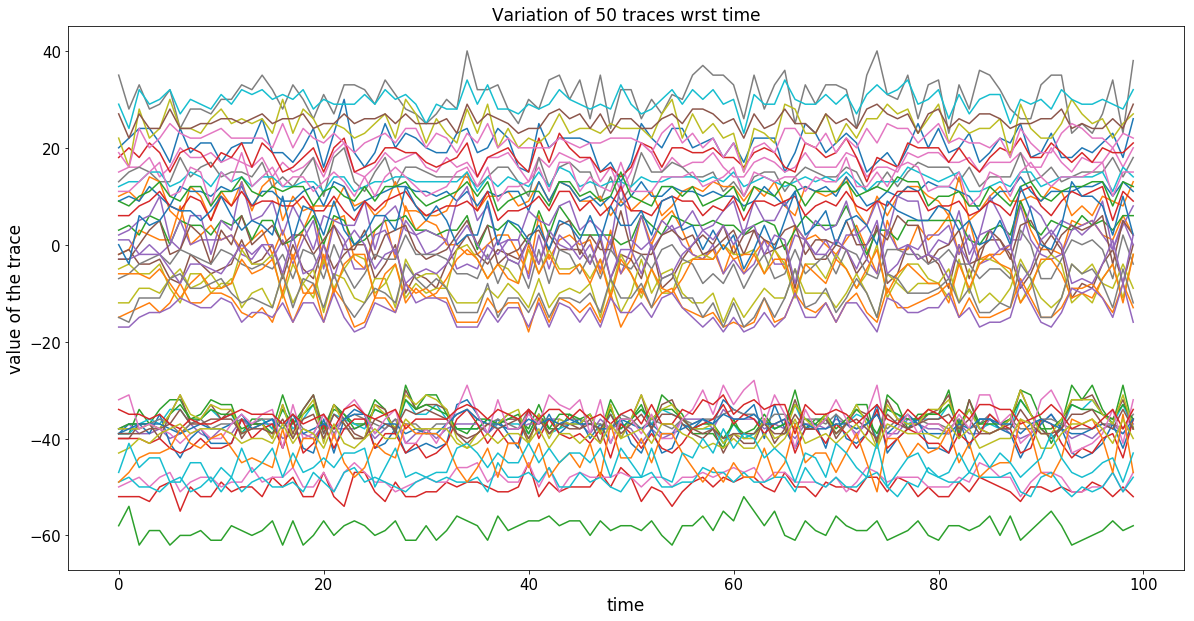

In [58]:
plt.figure(figsize=(20,10))
for i in [x*4 for x in range(50)]:
    plt.plot(df_train[i][:100])
plt.title("Variation of 50 traces wrst time",fontsize=17)
plt.xlabel("time",fontsize=17)
plt.xticks(fontsize=15)
plt.ylabel("value of the trace",fontsize=17)
plt.yticks(fontsize=15)
plt.show()

We have here the variation of ten electromagnetic traces over time.

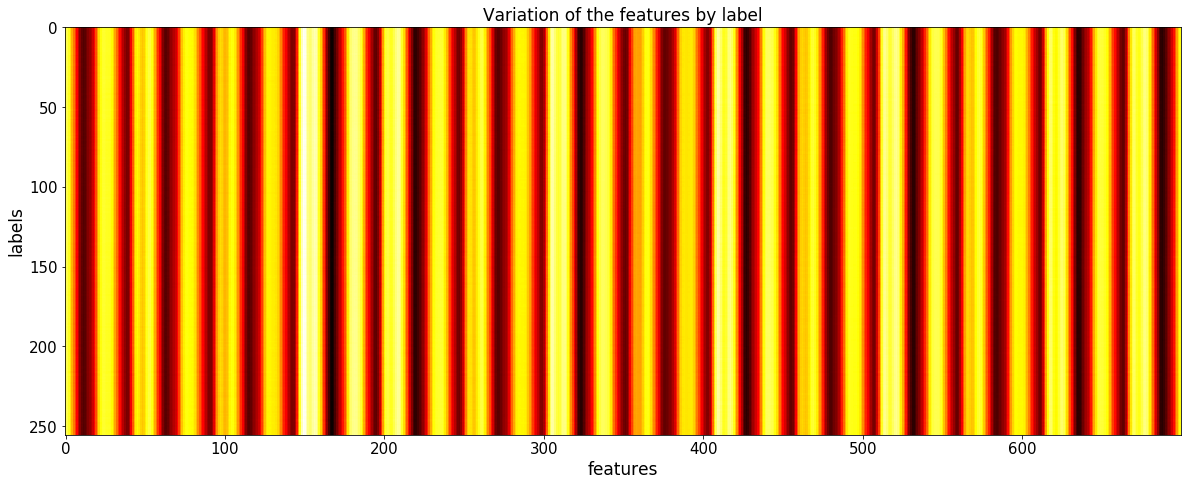

In [5]:
df_train_labelled = df_train.copy()
df_train_labelled[700] = y_train
u = df_train_labelled.groupby([700]).mean()

plt.figure(figsize=(20,10))

plt.imshow(u, cmap='hot', interpolation='nearest')
plt.title("Variation of the features by label",fontsize=17)
plt.xlabel("features",fontsize=17)
plt.xticks(fontsize=15)
plt.ylabel("labels",fontsize=17)
plt.yticks(fontsize=15)
plt.show()

In this figure, we computed for each label, the mean of the value of each feature. We can notice here that the features have the same mean irrespective of the label.

### The labels

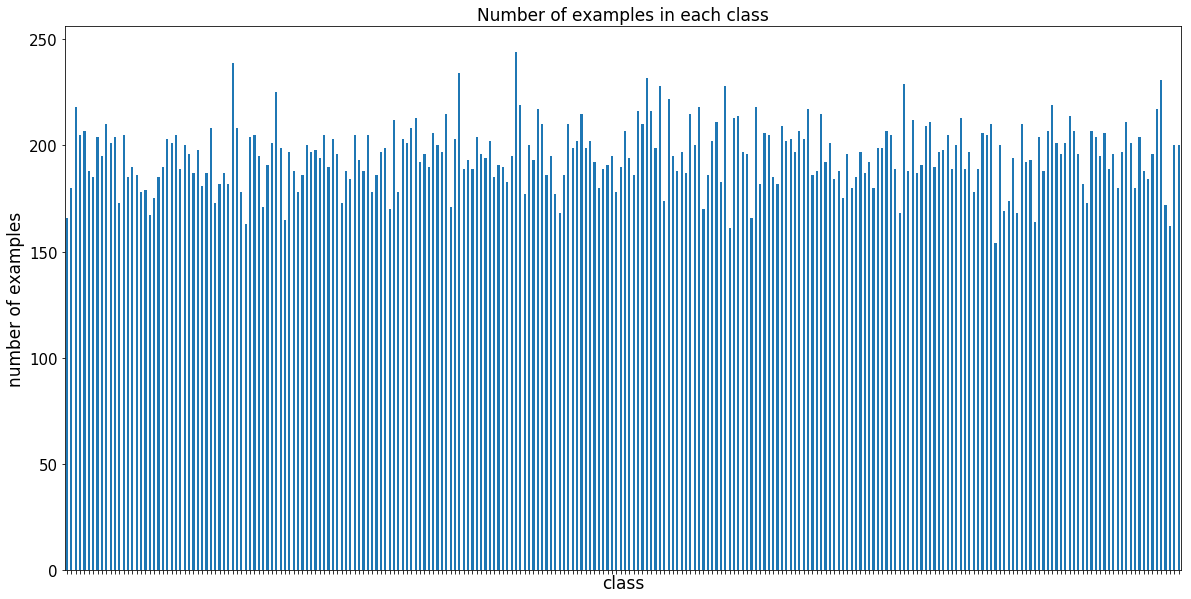

In [32]:
pd.DataFrame(np.unique(y_train, return_counts=True)[1]).plot(kind='bar', figsize=(20,10), legend=False)
plt.title("Number of examples in each class",fontsize=17)
plt.xlabel("class",fontsize=17)
plt.xticks(fontsize=15, visible=False)
plt.ylabel("number of examples",fontsize=17)
plt.yticks(fontsize=15)
plt.show()

We see that we have 256 different labels. Furthermore, the dataset is quite balanced.

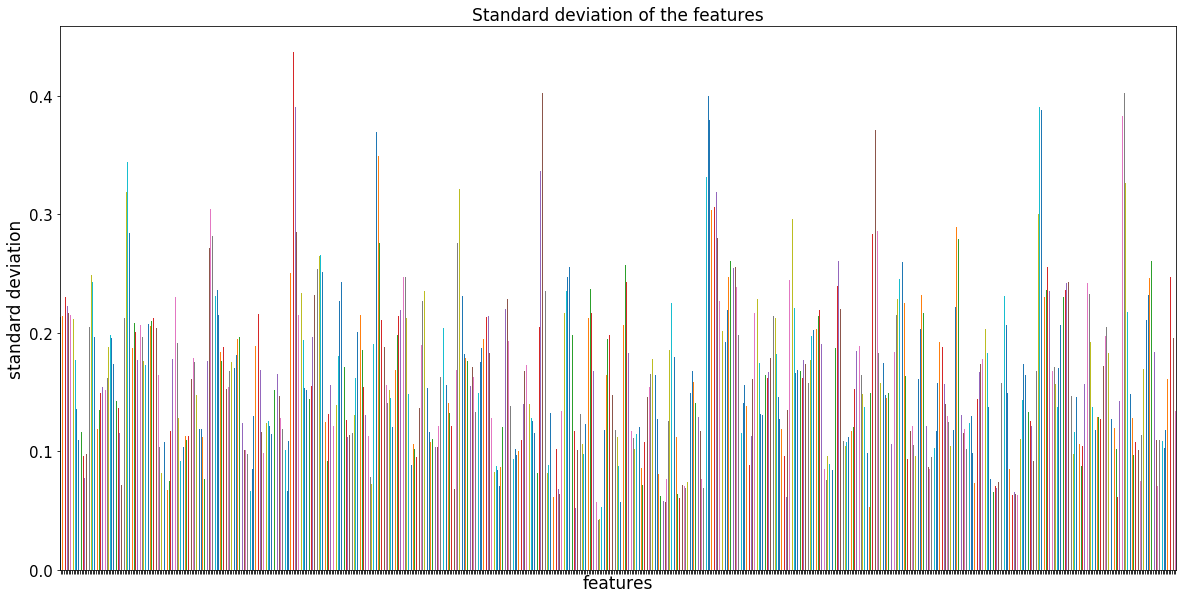

In [33]:
plt.figure(figsize=(20,10))
u.std().plot( kind='bar')
plt.title("Standard deviation of the features",fontsize=17)
plt.xlabel("features",fontsize=17)
plt.xticks(fontsize=15, visible=False)
plt.ylabel("standard deviation",fontsize=17)
plt.yticks(fontsize=15)
plt.show()

From this point of view and in light of these experiences, it seems the different features have globally the same behaviour. 

### Let's look at it more in details

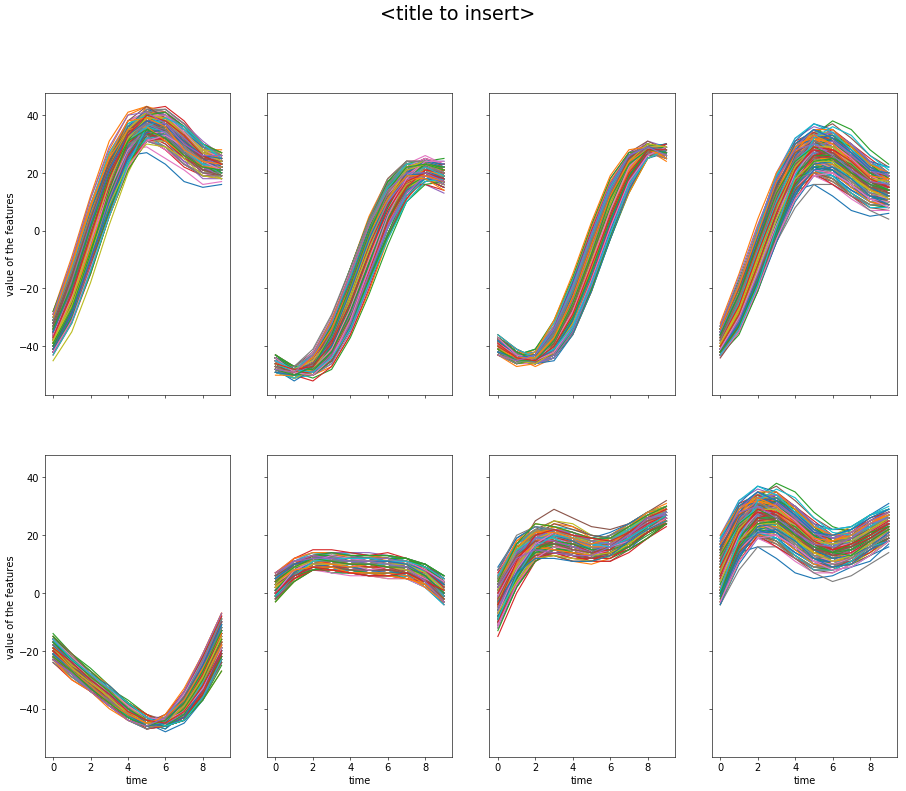

In [54]:
from sklearn.preprocessing import normalize

def plot_minima(minima,X_train,y_train,i,j,axs):
    for k in range(1,256):
            axs[i, j].plot(X_train[np.where(y_train == k)][0][minima-5:minima+5])

X_1 = normalize(X_train[np.where(y_train == 1)])
X_240 = normalize(X_train[np.where(y_train == 240)])

example = X_1[0]

local_max = np.r_[True, example[1:] > example[:-1]] & np.r_[example[:-1] > example[1:], True]
local_min = np.r_[True, example[1:] < example[:-1]] & np.r_[example[:-1] < example[1:], True]

maximum_idx = np.where(local_max == True)
minimas_idx = np.where(local_min == True)

n_sub = 0
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
plt.suptitle("<title to insert>",fontsize=25)
fig.set_size_inches(20,16)
fig.dpi=55

axs.ravel()[n_sub].set_ylabel('value of the features', fontsize=13) 
for maximum in [149,667,302,409]: #timestamps of maxima
    for i in range(1,256):
        axs.ravel()[n_sub].plot(X_train[np.where(y_train == i)][0][maximum-5:maximum+5])
        axs.ravel()[n_sub].tick_params(labelsize=13)
    n_sub += 1
        
axs.ravel()[n_sub].set_ylabel('value of the features', fontsize=13) 
for minimum in [90,130,204,412]: #timestamps of minima
    for i in range(1,256):
        axs.ravel()[n_sub].plot(X_train[np.where(y_train == i)][0][minimum-5:minimum+5])
        axs.ravel()[n_sub].set_xlabel('time', fontsize=13)
        axs.ravel()[n_sub].tick_params(labelsize=13)
    n_sub += 1

plt.show()    

We can notice these little differences in the extrema. It could 

### Score / Metric